In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts/ConceptBottleneck/')
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts')

In [3]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
import json
import argparse 
import secrets
import subprocess
import shutil 
from torch.nn.utils import prune

/usr0/home/naveenr/miniconda3/envs/concepts_spurious/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

In [13]:
is_jupyter = 'ipykernel' in sys.modules
if is_jupyter:
    num_objects = 2
    encoder_model='small3'
    seed = 42
    retrain_epochs = 0
    pruning_technique = 'weight'
    expand_dim_encoder = 0
    num_middle_encoder = 0
    prune_rate = 0.25
    dataset_name = "synthetic_object/synthetic_2"
else:
    parser = argparse.ArgumentParser(description="Synthetic Dataset Experiments")


    parser.add_argument('--num_objects', type=int, default=1, help='Number of objects')
    parser.add_argument('--encoder_model', type=str, default='small3', help='Encoder model')
    parser.add_argument('--seed', type=int, default=42, help='Random seed')
    parser.add_argument('--retrain_epochs', type=int, default=5, help='Number of epochs')
    parser.add_argument('--expand_dim_encoder', type=int, default=0, help='For MLPs, size of the middle layer')
    parser.add_argument('--num_middle_encoder', type=int, default=0, help='For MLPs, number of middle layers')
    parser.add_argument('--pruning_technique', type=str, default='weight', help='"layer" or "weight" pruning')
    parser.add_argument('--prune_rate', type=float, default=0.25, help='Rate of pruning')
    parser.add_argument('--dataset_name', type=str, default='synthetic_object/synthetic_1', help='Which dataset to use')

    args = parser.parse_args()
    num_objects = args.num_objects
    encoder_model = args.encoder_model 
    seed = args.seed 
    retrain_epochs = args.retrain_epochs 
    expand_dim_encoder = args.expand_dim_encoder
    num_middle_encoder = args.num_middle_encoder
    pruning_technique = args.pruning_technique 
    prune_rate = args.prune_rate
    dataset_name = args.dataset_name

parameters = {
    'seed': seed, 
    'encoder_model': encoder_model ,
    'retrain_epochs': retrain_epochs,
    'pruning_technique': pruning_technique,  
    'num_attributes': num_objects*2,
    'expand_dim_encoder': expand_dim_encoder, 
    'num_middle_encoder': num_middle_encoder, 
    'debugging': False,
    'prune_rate': prune_rate, 
    'dataset_name': dataset_name,
}
print(parameters)


{'seed': 42, 'encoder_model': 'small3', 'retrain_epochs': 0, 'pruning_technique': 'weight', 'num_attributes': 4, 'expand_dim_encoder': 0, 'num_middle_encoder': 0, 'debugging': False, 'prune_rate': 0.25, 'dataset_name': 'synthetic_object/synthetic_2'}


In [14]:
np.random.seed(seed)
torch.manual_seed(seed)

In [15]:
train_loader, val_loader, test_loader, train_pkl, val_pkl, test_pkl = get_data(num_objects,encoder_model=encoder_model,dataset_name=dataset_name)

In [16]:
test_images, test_y, test_c = unroll_data(test_loader)

In [17]:
rand_name = secrets.token_hex(4)
results_file = "../../results/pruning/{}.json".format(rand_name)
delete_same_dict("../../results/pruning",parameters)

Files to delete are []


In [18]:
model_parameters = {
    'debugging': False, 
    'epochs': 50,
    'encoder_model': encoder_model, 
    'seed': seed, 
    'num_attributes': num_objects*2,
    'expand_dim_encoder': expand_dim_encoder, 
    'num_middle_encoder': num_middle_encoder, 
}

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
joint_model = get_synthetic_model(dataset_name,model_parameters)

In [21]:
joint_model = joint_model.to(device)
if encoder_model == 'mlp':
    for i in range(len(joint_model.first_model.linear_layers)):
        joint_model.first_model.linear_layers[i] = joint_model.first_model.linear_layers[i].to(device) 

## Prune Model

In [22]:
if pruning_technique == "layer":
    for conv_number in [4,5,6,7]:
        if len(joint_model.first_model.conv_layers) >= conv_number: 
            layer_to_prune = joint_model.first_model.conv_layers[conv_number-1]
            weight = layer_to_prune.weight.data.abs().clone()
            importance = weight.sum((1, 2, 3))  # Calculate importance of filters
            num_filters = layer_to_prune.weight.size(0)

            # Compute the number of filters to prune
            num_prune = int(num_filters * prune_rate)
            _, indices = importance.sort(descending=True)
            indices_to_prune = indices[-num_prune:]

            # Create a mask to prune filters
            mask = torch.ones(num_filters)
            mask[indices_to_prune] = 0
            if mask is not None:
                mask = mask.to(layer_to_prune.weight.device)
                layer_to_prune.weight.data *= mask.view(-1, 1, 1, 1)    
elif pruning_technique == "weight":
    for layer in joint_model.first_model.children():
        if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
            torch.nn.utils.prune.l1_unstructured(layer, name="weight", amount=prune_rate) 
        elif isinstance(layer,torch.nn.ModuleList):
            for sub_layer in layer:
                if isinstance(sub_layer, torch.nn.Conv2d):
                    prune.l1_unstructured(sub_layer, name="weight", amount=prune_rate)
    if encoder_model != 'mlp':
        for layer in joint_model.first_model.all_fc:
            layer = layer.fc 
            prune.l1_unstructured(layer, name="weight", amount=prune_rate)
elif pruning_technique == "weight_fc":
    for layer in joint_model.first_model.all_fc:
        layer = layer.fc 
        prune.l1_unstructured(layer, name="weight", amount=prune_rate)
elif pruning_technique == "copy":
    joint_model_good = torch.load("../../models/pruned/synthetic/5f4f8ca6/joint/best_model_42.pth",map_location='cpu')
    for i in range(2,7):
        # joint_model.first_model.conv_layers[i] = joint_model_good.first_model.conv_layers[i]
        prune.l1_unstructured(joint_model.first_model.conv_layers[i], name="weight", amount=0.99)

    joint_model.first_model.all_fc = joint_model_good.first_model.all_fc
else:
    raise Exception("Pruning {} not found".format(pruning_technique))

## Retraining

In [23]:
torch.save(joint_model,open("../../models/pruned/synthetic/{}.pt".format(rand_name),"wb"))

In [24]:
joint_model = None 

In [25]:
torch.cuda.empty_cache()

In [26]:
command_to_run = "python train_cbm.py -dataset {} -epochs {} --load_model pruned/synthetic/{}.pt -num_attributes {} --encoder_model {} -num_classes 2 -seed {}".format(dataset_name,retrain_epochs,rand_name,num_objects*2,encoder_model,seed)

In [27]:
subprocess.run("cd ../../ConceptBottleneck && {}".format(command_to_run),shell=True)

Namespace(attr_loss_weight=1.0, batch_size=32, bottleneck=False, ckpt='0', connect_CY=False, data_dir='../../../datasets/synthetic_object/synthetic_2/preprocessed', dataset='cub', encoder_model='small3', end2end=True, epochs=0, exp='Joint', expand_dim=0, expand_dim_encoder=0, experiment_name='CUB', freeze=False, image_dir='images', load_model='pruned/synthetic/33755d36.pt', log_dir='../models/pruned/synthetic/33755d36/joint', lr=0.05, mask_loss_weight=1.0, n_attributes=4, n_class_attr=2, no_img=False, normalize_loss=True, num_classes=2, num_middle_encoder=0, one_batch=False, optimizer='sgd', pretrained=False, resampling=False, save_step=1000, scale_factor=1.5, scale_lr=5, scheduler='none', scheduler_step=30, seed=42, three_class=False, train_addition='', train_variation='none', uncertain_labels=False, use_attr=True, use_aux=True, use_relu=False, use_sigmoid=True, use_unknown=False, weight_decay=0.0004, weighted_loss='multiple')
[1, 1, 1, 1]
Stop epoch:  60
train data path: ../../../dat

CompletedProcess(args='cd ../../ConceptBottleneck && python train_cbm.py -dataset synthetic_object/synthetic_2 -epochs 0 --load_model pruned/synthetic/33755d36.pt -num_attributes 4 --encoder_model small3 -num_classes 2 -seed 42', returncode=0)

In [28]:
os.remove("../../models/pruned/synthetic/{}.pt".format(rand_name))

In [29]:
joint_location = "../../models/pruned/synthetic/{}/joint/best_model_{}.pth".format(rand_name,seed)
joint_model = torch.load(joint_location,map_location='cpu')

if 'encoder_model' in parameters and 'mlp' in parameters['encoder_model']:
    joint_model.encoder_model = True

r = joint_model.eval()

In [30]:
joint_model = joint_model.to(device)
if encoder_model == 'mlp':
    for i in range(len(joint_model.first_model.linear_layers)):
        joint_model.first_model.linear_layers[i] = joint_model.first_model.linear_layers[i].to(device) 

In [31]:
torch.cuda.empty_cache()

## Compute Activation + Accuracy

In [32]:
train_acc =  get_accuracy(joint_model,run_joint_model,train_loader)
val_acc = get_accuracy(joint_model,run_joint_model,val_loader)
test_acc =get_accuracy(joint_model,run_joint_model,test_loader)

In [33]:
train_acc, val_acc, test_acc  

(1.0, 1.0, 1.0)

In [34]:
def numpy_to_pil(img):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([2, 2, 2])

    unnormalized_image = img * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]
    unnormalized_image = unnormalized_image*255 
    unnormalized_image = np.clip(unnormalized_image, 0, 255).astype(np.uint8) 
    im = Image.fromarray(unnormalized_image.transpose(1,2,0))
    return im

[0.4, 0.8, 0.4, 0.4]

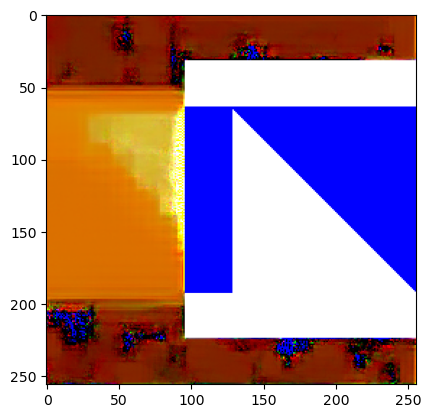

In [35]:
activation_values = []

for concept_num in range(num_objects*2):
    val_for_concept = 0
    trials = 5

    for _ in range(trials):
        data_point = random.randint(0,len(test_images)-1)
        input_image = deepcopy(test_images[data_point:data_point+1])
        current_concept_val = test_c[data_point][concept_num]

        ret_image = get_maximal_activation(joint_model,run_joint_model,concept_num,
                                        get_valid_image_function(concept_num,num_objects,epsilon=32),fixed_image=input_image,current_concept_val=current_concept_val).to(device)
        predicted_concept = torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1].detach().cpu())[concept_num][0].detach().numpy()
        
        val_for_concept += abs(predicted_concept-current_concept_val.detach().numpy())/trials 
        ret_image = ret_image.detach()[0].cpu().numpy()
        plt.imshow(numpy_to_pil(ret_image))
    activation_values.append(val_for_concept)
activation_values

In [36]:
shutil.rmtree("../../models/pruned/synthetic/{}".format(rand_name))

In [37]:
final_data = {
    'train_accuracy': train_acc, 
    'val_accuracy': val_acc, 
    'test_accuracy': test_acc, 
    'adversarial_activations': np.array(activation_values).tolist(),  
    'parameters': parameters,  
}

In [38]:
final_data

{'train_accuracy': 1.0,
 'val_accuracy': 1.0,
 'test_accuracy': 1.0,
 'adversarial_activations': [0.4, 0.8, 0.4, 0.4],
 'parameters': {'seed': 42,
  'encoder_model': 'small3',
  'retrain_epochs': 0,
  'pruning_technique': 'weight',
  'num_attributes': 4,
  'expand_dim_encoder': 0,
  'num_middle_encoder': 0,
  'debugging': False,
  'prune_rate': 0.25,
  'dataset_name': 'synthetic_object/synthetic_2'}}

: 

In [34]:
json.dump(final_data,open(results_file,"w"))